<h1>Testing the calibration</h1>

After we have confirmed what our E2E simulation images from WebbPSF look like, let's test the calibration script "calibration.py".

In [4]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import webbpsf

os.chdir('../python/')
from config import CONFIG_INI
import util_pastis as util
import image_pastis as impastis
import webbpsf_imaging as webbim

# Path to all the outputs from "aperture_definition.py".
dir = '/Users/ilaginja/Documents/data_from_repos/pastis_data/calibration'
# Change into that directory
os.chdir(dir)

In [5]:
# Define some useful random functions

# This one is copied from util_pastis and could just as well be used as util.zoom_cen().
def zoom(im, bb):
    """
    Cut out a square box from the image center with half-box size bb.
    :param im: image from which box will be taken
    :param bb: half-box size
    :return:
    """
    x = int(im.shape[1]/2)
    y = int(im.shape[0]/2)
    return(im[y-bb:y+bb, x-bb:x+bb])

In [6]:
# Load some parameters
fpm = CONFIG_INI.get('coronagraph', 'focal_plane_mask')                 # focal plane mask
lyot_stop = CONFIG_INI.get('coronagraph', 'pupil_plane_stop')   # Lyot stop
filter = CONFIG_INI.get('filter', 'name')
nb_seg = CONFIG_INI.getint('telescope', 'nb_subapertures')
wss_segs = webbpsf.constants.SEGNAMES_WSS_ORDER
zern_max = CONFIG_INI.getint('zernikes', 'max_zern')
nm_aber = CONFIG_INI.getfloat('calibration', 'single_aberration_nm')    # [nm] amplitude of aberration
zern_number = CONFIG_INI.getint('calibration', 'zernike')               # Which (Noll) Zernike we are calibrating for
wss_zern_nb = util.noll_to_wss(zern_number)                             # Convert from Noll to WSS framework

In [7]:
# Set up limits for zooming into images
im_size_e2e = CONFIG_INI.getint('numerical', 'im_size_px_webbpsf')   # image size in pixels
sampling = CONFIG_INI.getfloat('numerical', 'sampling')              # sampling
outer_wa = CONFIG_INI.getint('coronagraph', 'OWA')                   # outer working angle of coronagraph
tot_dh_im_size = sampling*(outer_wa+3)

## Load the direct PSF and coro PSF from E2E simulation

Let's first check the direct and coronagraphic PSF from the E2E simulation. The direct PSF from the E2E simulation will also be used for PSF normalization.

(320, 320)
(320, 320)


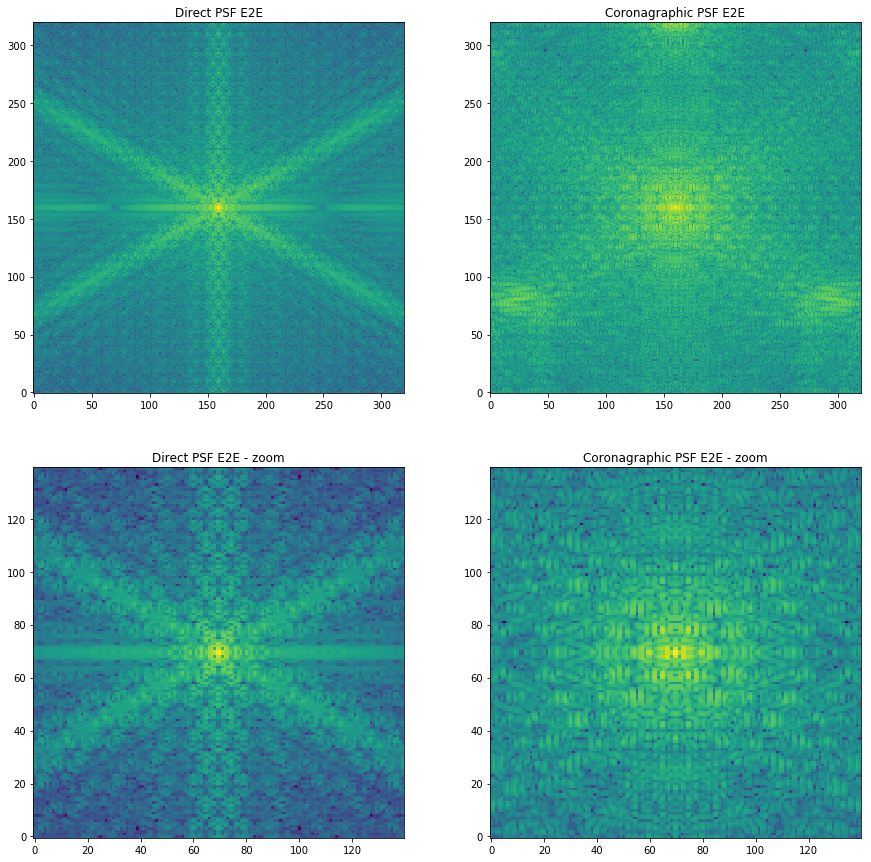

In [8]:
psf_direct = fits.getdata('psf_default.fits')
psf_coro = fits.getdata('psf_coro.fits')
print(psf_direct.shape)
print(psf_coro.shape)

im_range = 70

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(psf_direct, norm=LogNorm())
plt.title('Direct PSF E2E')

plt.subplot(2, 2, 2)
plt.imshow(psf_coro, norm=LogNorm())
plt.title('Coronagraphic PSF E2E')

plt.subplot(2, 2, 3)
plt.imshow(zoom(psf_direct, im_range), norm=LogNorm())
plt.title('Direct PSF E2E - zoom')

plt.subplot(2, 2, 4)
plt.imshow(zoom(psf_coro, im_range), norm=LogNorm())
plt.title('Coronagraphic PSF E2E - zoom')

plt.show()

## Load the dark hole array and check baseline contrast $C_0$

Load the dark hole and see what it looks like by itseld and when overlapped with the two images.

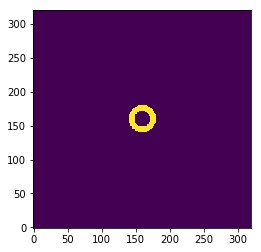

In [9]:
dh = fits.getdata('dh_area.fits')
plt.imshow(dh)
plt.show()

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  del sys.path[0]


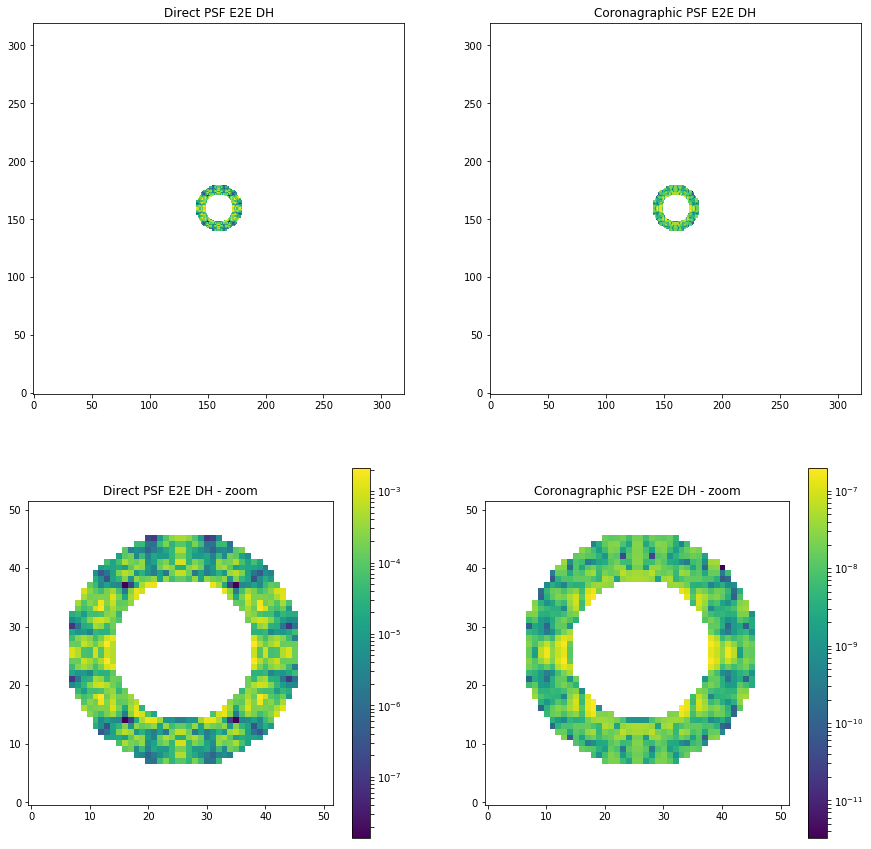

In [10]:
# DH over PSFs (dh over direct PSF is a useles concept, but I wanted to see what it looks like).

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.imshow(psf_direct*dh, norm=LogNorm())
plt.title('Direct PSF E2E DH')

plt.subplot(2, 2, 2)
plt.imshow(psf_coro*dh, norm=LogNorm())
plt.title('Coronagraphic PSF E2E DH')

plt.subplot(2, 2, 3)
plt.imshow(zoom((psf_direct*dh), tot_dh_im_size), norm=LogNorm())
plt.title('Direct PSF E2E DH - zoom')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(zoom((psf_coro*dh), tot_dh_im_size), norm=LogNorm())
plt.title('Coronagraphic PSF E2E DH - zoom')
plt.colorbar()

plt.show()

Read in the baseline contrast to see what it is. You will have to adjust the file name. Then compare it to what we read out of the image ourselves.

In [11]:
blcontr = np.loadtxt('base-contrast_piston_Noll1.txt')
print('Baseline contrast E2E simulation from file: C_0 =', blcontr)

con_dir = np.mean((psf_direct*dh)[np.where((psf_direct*dh) != 0)])
con_coro = np.mean((psf_coro*dh)[np.where((psf_coro*dh) != 0)])

print('Contrast direct PSF:', con_dir)
print('Contrast coro PSF:', con_coro)

Baseline contrast E2E simulation from file: C_0 = 2.235765818430869e-08
Contrast direct PSF: 0.000231065034916
Contrast coro PSF: 2.23576581843e-08


## Generate direct PSF for normalization

In [12]:
# Create a direct WebbPSF image for normalization factor
fake_aber = np.zeros([nb_seg, zern_max])
psf_perfect = webbim.nircam_nocoro(filter, fake_aber)
normp = np.max(psf_perfect)
psf_perfect = psf_perfect / normp
print(normp)

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


0.141665326499


## Set up the coro NIRCam object

In [13]:
# Set up coro object
nc_coro = webbpsf.NIRCam()
nc_coro.filter = filter

# Add coronagraphic elements to nc_coro
nc_coro.image_mask = fpm
nc_coro.pupil_mask = lyot_stop

# Null the OTE OPDs for the coro PSF, maybe we will add internal WFE later.
nc_coro, ote_coro = webbpsf.enable_adjustable_ote(nc_coro)      # create OTE for coronagraph
ote_coro.zero()                   # set OTE for coronagraph to zero
nc_coro.include_si_wfe = False    # set SI internal WFE to zero

## Calibrate the segments one by one

We will walk through each segment on the OTE, aberrate it, make an image with it and record it. Then we'll also generate an (uncalibrated) analytical image with the same single-segment aberration and compare the two.

In [14]:
# Pick what segment to work on
segnum = 4
###########
i = segnum - 1     # segment nubers start at 1, but Python numbering starts at 0

seg = wss_segs[i].split('-')[0]
print('Working on segment ' + seg)

Working on segment A4


Applying aberration to OTE.
nm_aber =  100.0 nm


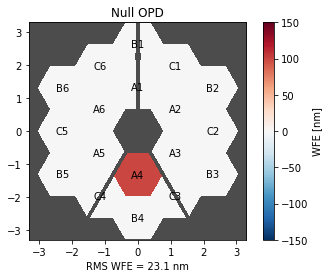

In [15]:
# Create arrays to hold Zernike aberration coefficients
Aber_WSS = np.zeros([nb_seg, zern_max])           # The Zernikes here will be filled in the WSS order!!!
                                                  # Because it goes into _apply_hexikes_to_seg().
Aber_Noll = np.copy(Aber_WSS)                     # This is the Noll version for imput into PASTIS.

# Feed the aberration nm_aber into the array position
# that corresponds to the correct Zernike, but only on segment i
Aber_WSS[i, wss_zern_nb-1] = nm_aber / 1e9        # Aberration on the segment we're currently working on;
                                                  # convert to meters; -1 on the Zernike because Python starts
                                                  # numbering at 0.
Aber_Noll[i, zern_number-1] = nm_aber             # Noll version - in nm!

#-# Crate OPD with aberrated segment(s)
print('Applying aberration to OTE.')
print('nm_aber = ', nm_aber, 'nm')
ote_coro.reset()   # Making sure there are no previous movements on the segments.
ote_coro.zero()    # For now, ignore internal WFE.
ote_coro._apply_hexikes_to_seg(seg, Aber_WSS[i,:])

ote_coro.display_opd()
plt.show()

In [16]:
# Calculate coronagraphic PSF from E2E sim
psf_endsim = nc_coro.calc_psf(fov_pixels=int(im_size_e2e), oversample=1, nlambda=1)
psf_end = psf_endsim[0].data

# Normalize coro PSF
psf_end = psf_end / normp

Pysynphot unavailable (or invalid source supplied)!   Assuming flat # of counts versus wavelength.
CAUTION: Just interpolating rather than integrating filter profile, over 1 steps


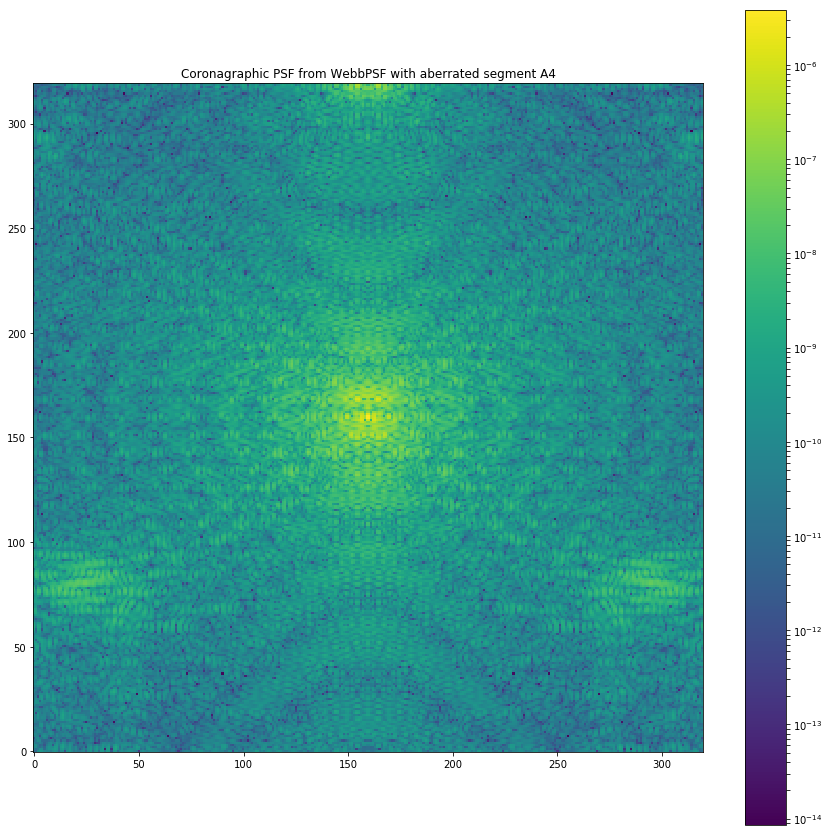

In [17]:
# Display calculated PSF
plt.figure(figsize=(15, 15))
plt.imshow(psf_end, norm=LogNorm(), origin='lower')
plt.title('Coronagraphic PSF from WebbPSF with aberrated segment ' + seg)
plt.colorbar()
plt.show()

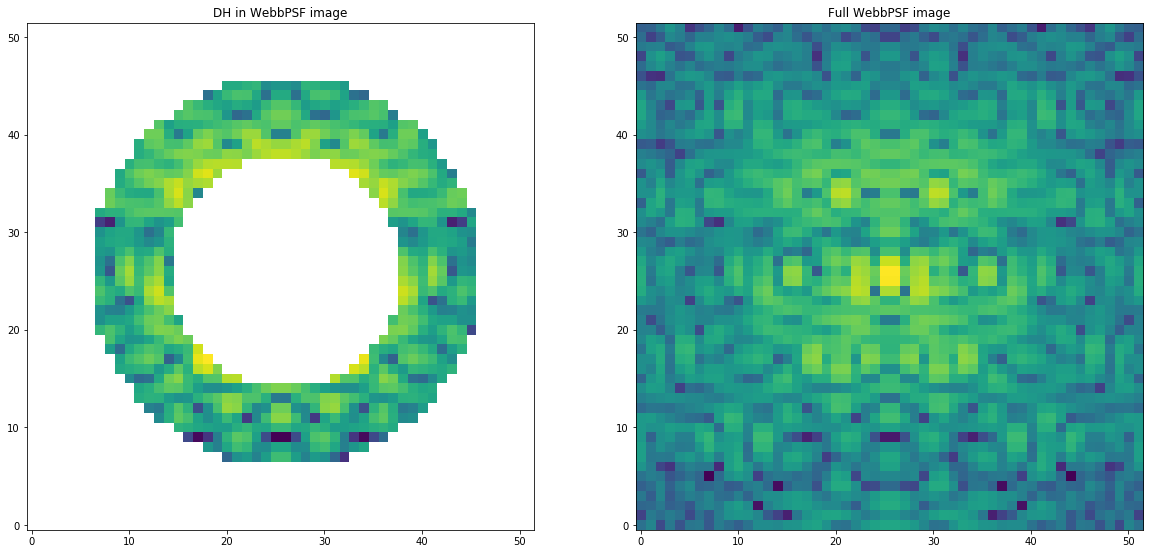

WebbPSF contrast =  5.38174632314e-08


In [23]:
# Display the dark hole and calculate contrast
im_end = psf_end * dh
contrast_e2e = np.mean(im_end[np.where(im_end != 0)])

imext = 26

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(zoom(im_end, imext), norm=LogNorm(), origin='lower')
plt.title('DH in WebbPSF image')
plt.subplot(1, 2, 2)
plt.imshow(zoom(psf_end, imext), norm=LogNorm(), origin='lower')
plt.title('Full WebbPSF image')
plt.show()

print('WebbPSF contrast = ', contrast_e2e)

In [19]:
# Calculate coronagraphic PSF from analytical model
dh_im_am, full_im_am = impastis.analytical_model(zern_number, Aber_Noll[:, zern_number-1], cali=False)
contrast_pastis = np.mean(dh_im_am[np.where(dh_im_am != 0)])

/Users/ilaginja/anaconda/envs/pastis/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((239, 239), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/ilaginja/Documents/Git/PASTIS/python/util_pastis.py:79: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return im[y-bb:y+bb, x-bb:x+bb]


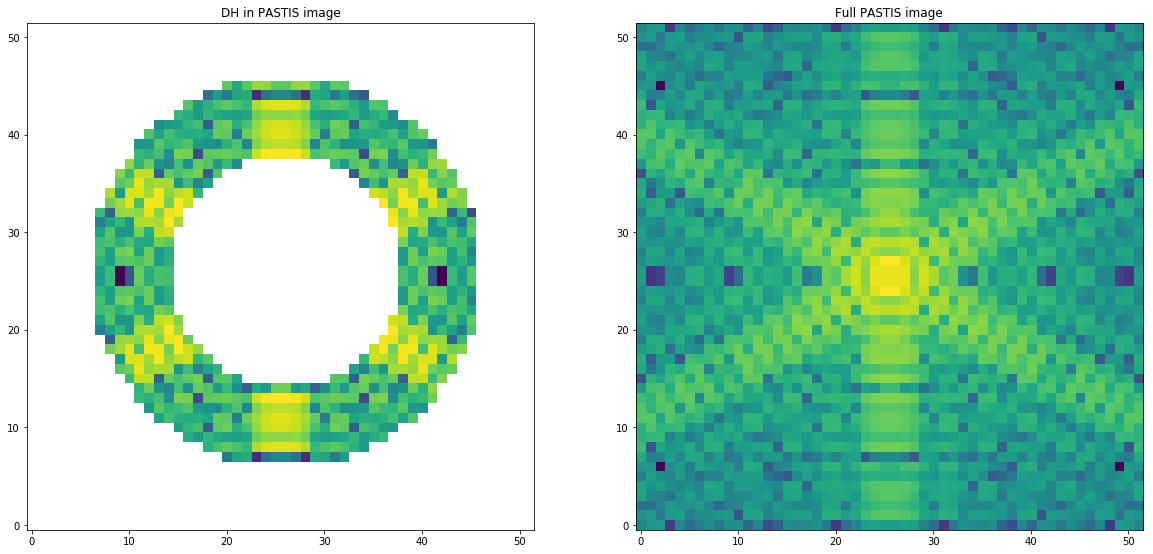

Uncalibrated PASTIS image contrast =  6861.11845064


In [26]:
# Display the dark hole and (uncalibrated!) contrast
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(zoom(dh_im_am, imext), norm=LogNorm(), origin='lower')
plt.title('DH in PASTIS image')
plt.subplot(1, 2, 2)
plt.imshow(zoom(full_im_am, imext), norm=LogNorm(), origin='lower')
plt.title('Full PASTIS image')
plt.show()

print('Uncalibrated PASTIS image contrast = ', contrast_pastis)

In [ ]:
# Calculate the calibration value for current segment
cali = np.sqrt((contrast_e2e - blcontr) / contrast_pastis)

print('Calibration coefficient for segment ', seg, '=', cali)

## Read in results from calibration run in real script

Let's have a look at the results from the real calibration script.

In her codes, Lucie also plots the contrast vs. the segment number, although this is not something really important. Just because, we can do it too:

In [28]:
# Read in contrast values form WebbPSF and uncalibrated PASTIS images form during calibration
con_webbpsf = fits.getdata('calibration_contrast_IMAGE-PASTIS_piston_Noll1.fits')
con_pastis = fits.getdata('calibration_contrast_WEBBPSF_piston_Noll1.fits')

segrange = np.arange(1, nb_seg+1)

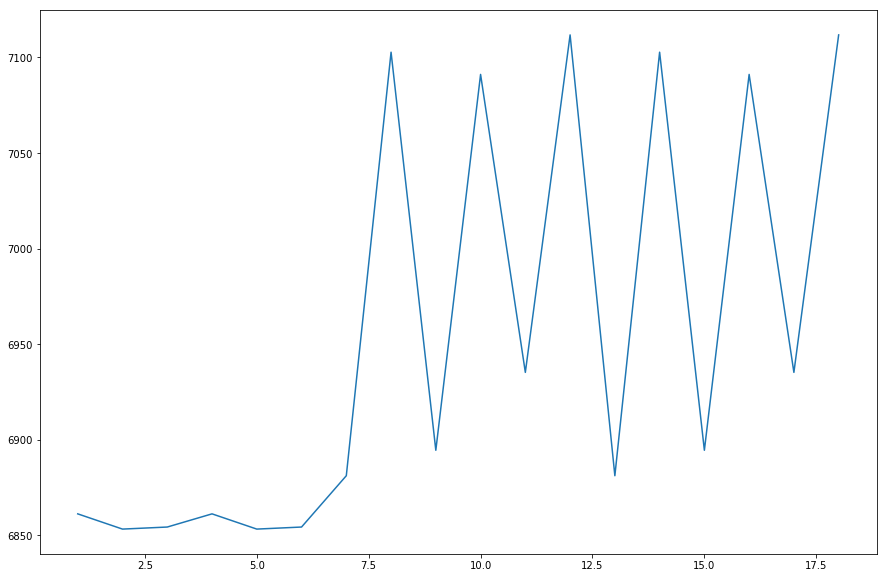

In [34]:
# And plot them
plt.figure(figsize=(15, 10))
plt.plot(segrange, con_webbpsf)
plt.title('Uncalibrated PASTIS DH contrast per segment')
plt.show()

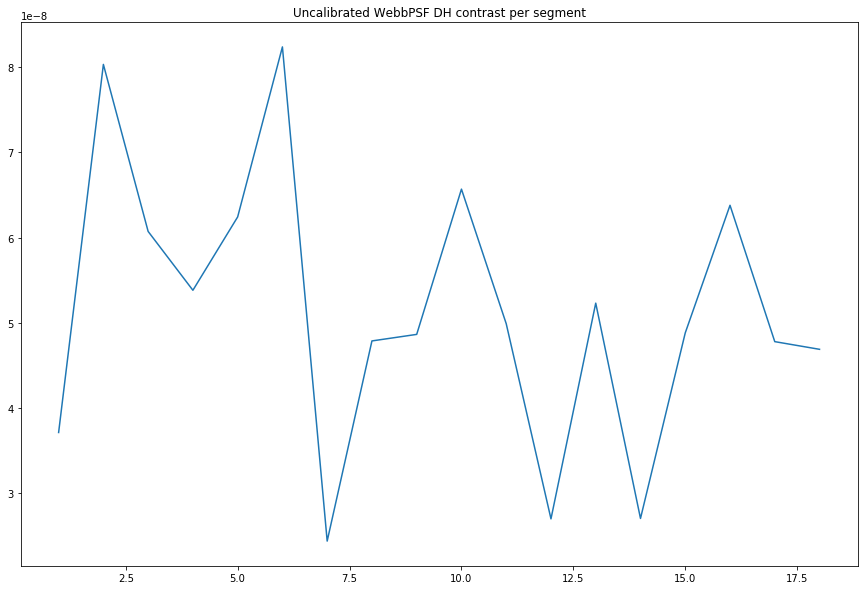

In [35]:
plt.figure(figsize=(15, 10))
plt.plot(segrange, con_pastis)
plt.title('Uncalibrated WebbPSF DH contrast per segment')
plt.show()

Not much to see here. Let's have a look at the calibration coefficients too.

In [39]:
calis = fits.getdata('calibration_piston_Noll1.fits')
print('Calibration coefficients:')
print(calis)

calibration coefficients:
[  2.15503653e-12   8.45359857e-12   5.59591508e-12   4.58522984e-12
   5.84475193e-12   8.75160941e-12   2.98977415e-13   3.59300996e-12
   3.81275510e-12   6.10807727e-12   3.97138387e-12   6.55638443e-13
   4.35235384e-12   6.63354730e-13   3.83833295e-12   5.84106806e-12
   3.66784567e-12   3.45020805e-12]


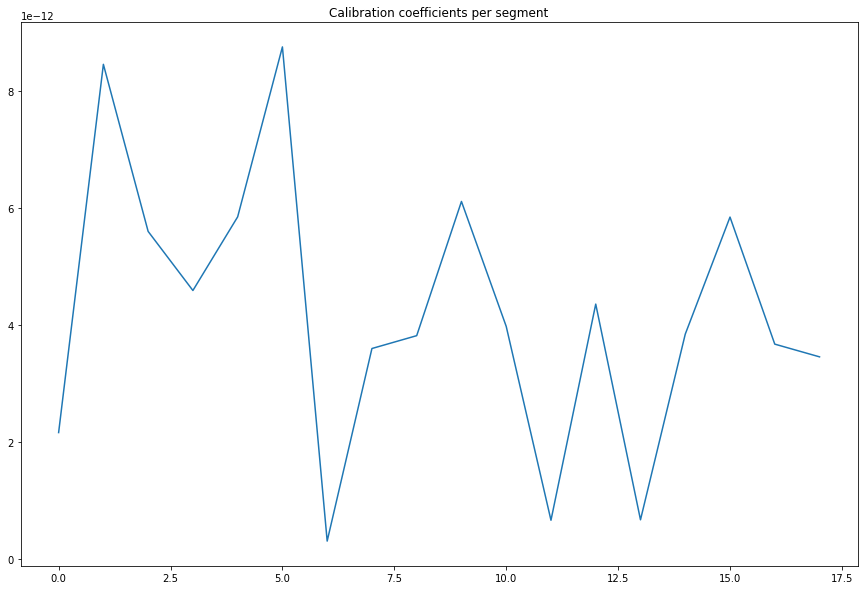

In [47]:
plt.figure(figsize=(15, 10))
plt.plot(calis)
plt.title('Calibration coefficients per segment')
plt.show()